In [31]:
import os, json
import numpy as np
import models
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from engine import train, validate, test
from dataset import ClevrPOCDataSet
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
from torchmetrics.classification import BinaryHammingDistance
import pickle


In [32]:
DATA_FOLDER_NAME = 'output-12000'
DATA_FOLDER = '/home/code/CLEVR-POC/clevr-poc-dataset-gen/' + DATA_FOLDER_NAME + '/incomplete'
ENVIRONMENT_FOLDER = '/home/code/CLEVR-POC/clevr-poc-dataset-gen/environment_constraints'

In [33]:

with open(os.path.join('/home/code/CLEVR-POC/clevr-poc-dataset-gen', 'data', 'properties.json'), encoding="utf-8") as f:
    properties = json.load(f)


key_properties_values = []
for key_property in properties:
    if key_property == 'regions':
        continue
    key_properties_values.extend(properties[key_property].keys())

total_labels_to_index = {k: v for v, k in enumerate(key_properties_values)}
total_labels_to_index


{'cube': 0,
 'sphere': 1,
 'cylinder': 2,
 'cone': 3,
 'gray': 4,
 'red': 5,
 'blue': 6,
 'green': 7,
 'brown': 8,
 'purple': 9,
 'cyan': 10,
 'yellow': 11,
 'rubber': 12,
 'metal': 13,
 'large': 14,
 'medium': 15,
 'small': 16}

In [34]:

matplotlib.style.use('ggplot')
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
#clip_model_path = "openai/clip-vit-base-patch32"
#clip_model, clip_preprocess = clip.load('ViT-B/32', device)


In [38]:
#intialize the model

clip_embedding_dim = 512
env_embedding_dim = 768
clip_model, final_classifier = models.model(requires_grad=False, 
                                      clip_model = clip_model,
                                      #checkpoint=clip_model_path,
                                      clip_embedding_dim=clip_embedding_dim,
                                      env_embedding_dim = env_embedding_dim,
                                      output_dim=len(total_labels_to_index))

clip_model.to(device)
final_classifier.to(device)

dropout = nn.Dropout(0.1) # ????

# learning parameters
lr = 0.001
epochs = 200
batch_size = 8
optimizer = optim.Adam(final_classifier.parameters(), lr=lr)

criterion = nn.BCELoss(reduction = 'none')
#pos_weight = torch.ones([len(total_labels_to_index)]).to(device)
#criterion = nn.BCEWithLogitsLoss(pos_weight)
#criterion = BinaryHammingDistance().to(device)

dropout = nn.Dropout(0.1)

validation_threshold = 0.5



In [39]:
# train dataset
train_data = ClevrPOCDataSet(DATA_FOLDER, 'training', total_labels_to_index, ENVIRONMENT_FOLDER)

# validation dataset
valid_data = ClevrPOCDataSet(DATA_FOLDER, 'validation', total_labels_to_index, ENVIRONMENT_FOLDER)

# train data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# validation data loader
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

print('a')

a


In [37]:
# start the training and validation
train_loss = []
valid_loss = []
valid_acc = []
best_validation_acc = 0
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(final_classifier, clip_model, train_loader, optimizer, criterion, train_data, device, dropout, clip_preprocess)
    valid_epoch_loss, valid_epoch_acc = validate(final_classifier, clip_model, valid_loader, criterion, valid_data, device, dropout, clip_preprocess, validation_threshold)
    if best_validation_acc < valid_epoch_acc:
        best_validation_acc = valid_epoch_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': final_classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'outputs/best_model_' + DATA_FOLDER_NAME + '.pth')

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    valid_acc.append(valid_epoch_acc)
    
    with open('outputs/train_loss_' + DATA_FOLDER_NAME + '.pickle', 'wb') as f:
        pickle.dump(train_loss, f)
    with open('outputs/val_loss_' + DATA_FOLDER_NAME + '.pickle', 'wb') as f:
        pickle.dump(valid_loss, f)
    with open('outputs/val_acc_' + DATA_FOLDER_NAME + '.pickle', 'wb') as f:
        pickle.dump(valid_acc, f)        
     
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')
    print(f'Val Acc: {valid_epoch_acc:.4f}')

Epoch 1 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [12:29<00:00,  2.00it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [01:10<00:00,  2.12it/s]


Train Loss: 0.6959
Val Loss: 0.6001
Val Acc: 0.0000
Epoch 2 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.5772
Val Loss: 0.5842
Val Acc: 0.0000
Epoch 3 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.5389
Val Loss: 0.5314
Val Acc: 0.0000
Epoch 4 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.5168
Val Loss: 0.5063
Val Acc: 0.0000
Epoch 5 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.58it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.4983
Val Loss: 0.5043
Val Acc: 0.0133
Epoch 6 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.4876
Val Loss: 0.4920
Val Acc: 0.0133
Epoch 7 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.58it/s]


Train Loss: 0.4775
Val Loss: 0.4937
Val Acc: 0.0067
Epoch 8 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.67it/s]


Train Loss: 0.4681
Val Loss: 0.4717
Val Acc: 0.0267
Epoch 9 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.4605
Val Loss: 0.4663
Val Acc: 0.0133
Epoch 10 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.4546
Val Loss: 0.4632
Val Acc: 0.0200
Epoch 11 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.4492
Val Loss: 0.4585
Val Acc: 0.0133
Epoch 12 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.4430
Val Loss: 0.4532
Val Acc: 0.0267
Epoch 13 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.4387
Val Loss: 0.4632
Val Acc: 0.0400
Epoch 14 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.56it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.4347
Val Loss: 0.4445
Val Acc: 0.0333
Epoch 15 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.4320
Val Loss: 0.4393
Val Acc: 0.0400
Epoch 16 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:12<00:00, 12.31it/s]


Train Loss: 0.4272
Val Loss: 0.4406
Val Acc: 0.0533
Epoch 17 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.63it/s]


Train Loss: 0.4236
Val Loss: 0.4420
Val Acc: 0.0467
Epoch 18 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.4211
Val Loss: 0.4323
Val Acc: 0.0267
Epoch 19 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.56it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.4191
Val Loss: 0.4421
Val Acc: 0.0333
Epoch 20 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.4167
Val Loss: 0.4569
Val Acc: 0.1000
Epoch 21 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.58it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.4138
Val Loss: 0.4342
Val Acc: 0.0733
Epoch 22 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.4100
Val Loss: 0.4288
Val Acc: 0.0267
Epoch 23 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.56it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.4103
Val Loss: 0.4311
Val Acc: 0.0733
Epoch 24 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.65it/s]


Train Loss: 0.4075
Val Loss: 0.4286
Val Acc: 0.0467
Epoch 25 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.66it/s]


Train Loss: 0.4042
Val Loss: 0.4227
Val Acc: 0.0533
Epoch 26 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.57it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.4049
Val Loss: 0.4232
Val Acc: 0.0400
Epoch 27 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.58it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.66it/s]


Train Loss: 0.4005
Val Loss: 0.4341
Val Acc: 0.0333
Epoch 28 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.56it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.4003
Val Loss: 0.4229
Val Acc: 0.0533
Epoch 29 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.3971
Val Loss: 0.4399
Val Acc: 0.0733
Epoch 30 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.58it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.62it/s]


Train Loss: 0.3953
Val Loss: 0.4634
Val Acc: 0.1133
Epoch 31 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:12<00:00, 12.46it/s]


Train Loss: 0.3953
Val Loss: 0.4286
Val Acc: 0.0400
Epoch 32 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.59it/s]


Train Loss: 0.3928
Val Loss: 0.4116
Val Acc: 0.0400
Epoch 33 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.67it/s]


Train Loss: 0.3911
Val Loss: 0.4239
Val Acc: 0.0400
Epoch 34 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.3905
Val Loss: 0.4216
Val Acc: 0.0333
Epoch 35 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.55it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.67it/s]


Train Loss: 0.3896
Val Loss: 0.4239
Val Acc: 0.0667
Epoch 36 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.3878
Val Loss: 0.4186
Val Acc: 0.0667
Epoch 37 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.3877
Val Loss: 0.4128
Val Acc: 0.0667
Epoch 38 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.3870
Val Loss: 0.4472
Val Acc: 0.0467
Epoch 39 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.59it/s]


Train Loss: 0.3870
Val Loss: 0.4053
Val Acc: 0.1133
Epoch 40 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.66it/s]


Train Loss: 0.3837
Val Loss: 0.4212
Val Acc: 0.0933
Epoch 41 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.58it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.3837
Val Loss: 0.4135
Val Acc: 0.0600
Epoch 42 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.58it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.3818
Val Loss: 0.4107
Val Acc: 0.0667
Epoch 43 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.62it/s]


Train Loss: 0.3814
Val Loss: 0.4166
Val Acc: 0.0600
Epoch 44 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.57it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.3799
Val Loss: 0.4125
Val Acc: 0.0733
Epoch 45 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.3811
Val Loss: 0.4243
Val Acc: 0.0600
Epoch 46 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.58it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.3784
Val Loss: 0.4105
Val Acc: 0.1200
Epoch 47 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.56it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.60it/s]


Train Loss: 0.3799
Val Loss: 0.4037
Val Acc: 0.0933
Epoch 48 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.59it/s]


Train Loss: 0.3769
Val Loss: 0.4106
Val Acc: 0.0867
Epoch 49 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.54it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.3755
Val Loss: 0.4090
Val Acc: 0.0933
Epoch 50 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.65it/s]


Train Loss: 0.3744
Val Loss: 0.4057
Val Acc: 0.1067
Epoch 51 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.56it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.3755
Val Loss: 0.4186
Val Acc: 0.1267
Epoch 52 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.3743
Val Loss: 0.4098
Val Acc: 0.0867
Epoch 53 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.56it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.3721
Val Loss: 0.4158
Val Acc: 0.0800
Epoch 54 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.64it/s]


Train Loss: 0.3715
Val Loss: 0.4060
Val Acc: 0.0800
Epoch 55 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:12<00:00, 12.45it/s]


Train Loss: 0.3719
Val Loss: 0.4076
Val Acc: 0.0867
Epoch 56 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.3708
Val Loss: 0.4035
Val Acc: 0.0800
Epoch 57 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.58it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.3696
Val Loss: 0.4004
Val Acc: 0.0933
Epoch 58 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.61it/s]


Train Loss: 0.3691
Val Loss: 0.3969
Val Acc: 0.0667
Epoch 59 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.65it/s]


Train Loss: 0.3685
Val Loss: 0.3968
Val Acc: 0.0867
Epoch 60 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.58it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.3681
Val Loss: 0.4034
Val Acc: 0.0667
Epoch 61 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.3678
Val Loss: 0.3967
Val Acc: 0.0800
Epoch 62 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.57it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.3689
Val Loss: 0.3966
Val Acc: 0.0933
Epoch 63 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.3667
Val Loss: 0.4020
Val Acc: 0.1200
Epoch 64 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.65it/s]


Train Loss: 0.3655
Val Loss: 0.3927
Val Acc: 0.0667
Epoch 65 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.3658
Val Loss: 0.3989
Val Acc: 0.1067
Epoch 66 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.3653
Val Loss: 0.4041
Val Acc: 0.0800
Epoch 67 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.3647
Val Loss: 0.3893
Val Acc: 0.0933
Epoch 68 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.66it/s]


Train Loss: 0.3631
Val Loss: 0.3999
Val Acc: 0.0667
Epoch 69 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.57it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.3631
Val Loss: 0.3974
Val Acc: 0.1067
Epoch 70 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.3654
Val Loss: 0.4064
Val Acc: 0.1000
Epoch 71 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:12<00:00, 12.42it/s]


Train Loss: 0.3617
Val Loss: 0.4001
Val Acc: 0.1600
Epoch 72 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.3615
Val Loss: 0.4028
Val Acc: 0.1000
Epoch 73 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.3632
Val Loss: 0.3907
Val Acc: 0.0933
Epoch 74 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.57it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.3604
Val Loss: 0.3970
Val Acc: 0.0933
Epoch 75 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.3587
Val Loss: 0.3951
Val Acc: 0.1267
Epoch 76 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.58it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.3606
Val Loss: 0.4034
Val Acc: 0.1267
Epoch 77 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.3600
Val Loss: 0.3971
Val Acc: 0.1267
Epoch 78 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.3601
Val Loss: 0.4096
Val Acc: 0.1200
Epoch 79 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.3605
Val Loss: 0.4017
Val Acc: 0.0867
Epoch 80 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.3596
Val Loss: 0.3984
Val Acc: 0.1133
Epoch 81 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.3581
Val Loss: 0.3831
Val Acc: 0.1067
Epoch 82 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.3592
Val Loss: 0.3882
Val Acc: 0.1400
Epoch 83 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.3567
Val Loss: 0.3963
Val Acc: 0.0733
Epoch 84 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.3566
Val Loss: 0.4000
Val Acc: 0.1067
Epoch 85 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.3565
Val Loss: 0.3902
Val Acc: 0.1067
Epoch 86 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.3593
Val Loss: 0.3903
Val Acc: 0.1267
Epoch 87 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.66it/s]


Train Loss: 0.3556
Val Loss: 0.3893
Val Acc: 0.1533
Epoch 88 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.81it/s]


Train Loss: 0.3548
Val Loss: 0.3955
Val Acc: 0.0867
Epoch 89 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.3551
Val Loss: 0.3920
Val Acc: 0.1400
Epoch 90 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.57it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.3535
Val Loss: 0.3849
Val Acc: 0.1067
Epoch 91 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.3584
Val Loss: 0.3958
Val Acc: 0.1600
Epoch 92 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.3522
Val Loss: 0.3894
Val Acc: 0.1200
Epoch 93 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.3529
Val Loss: 0.3987
Val Acc: 0.1200
Epoch 94 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:12<00:00, 12.43it/s]


Train Loss: 0.3515
Val Loss: 0.3990
Val Acc: 0.1533
Epoch 95 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.3557
Val Loss: 0.3990
Val Acc: 0.0933
Epoch 96 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.3534
Val Loss: 0.3874
Val Acc: 0.1133
Epoch 97 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.3511
Val Loss: 0.3911
Val Acc: 0.1267
Epoch 98 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.3532
Val Loss: 0.3897
Val Acc: 0.1200
Epoch 99 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.61it/s]


Train Loss: 0.3529
Val Loss: 0.3861
Val Acc: 0.1533
Epoch 100 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.3524
Val Loss: 0.3909
Val Acc: 0.1067
Epoch 101 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.3517
Val Loss: 0.3917
Val Acc: 0.1133
Epoch 102 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.66it/s]


Train Loss: 0.3492
Val Loss: 0.3959
Val Acc: 0.0933
Epoch 103 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.3505
Val Loss: 0.4045
Val Acc: 0.1467
Epoch 104 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.3491
Val Loss: 0.3967
Val Acc: 0.1267
Epoch 105 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.3504
Val Loss: 0.4088
Val Acc: 0.0867
Epoch 106 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.57it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.3504
Val Loss: 0.3946
Val Acc: 0.1467
Epoch 107 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.79it/s]


Train Loss: 0.3514
Val Loss: 0.3846
Val Acc: 0.1200
Epoch 108 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.3499
Val Loss: 0.3925
Val Acc: 0.0933
Epoch 109 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.3493
Val Loss: 0.3930
Val Acc: 0.1133
Epoch 110 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:12<00:00, 12.49it/s]


Train Loss: 0.3489
Val Loss: 0.3928
Val Acc: 0.1133
Epoch 111 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.3491
Val Loss: 0.3929
Val Acc: 0.1000
Epoch 112 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.3504
Val Loss: 0.3852
Val Acc: 0.1800
Epoch 113 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.3469
Val Loss: 0.3964
Val Acc: 0.1467
Epoch 114 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.3473
Val Loss: 0.3834
Val Acc: 0.1067
Epoch 115 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.3498
Val Loss: 0.3925
Val Acc: 0.1400
Epoch 116 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.3472
Val Loss: 0.4098
Val Acc: 0.1600
Epoch 117 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.66it/s]


Train Loss: 0.3467
Val Loss: 0.3908
Val Acc: 0.1067
Epoch 118 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.3454
Val Loss: 0.3929
Val Acc: 0.1467
Epoch 119 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.66it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.3454
Val Loss: 0.3921
Val Acc: 0.1200
Epoch 120 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.3459
Val Loss: 0.3841
Val Acc: 0.1133
Epoch 121 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.3498
Val Loss: 0.3882
Val Acc: 0.1667
Epoch 122 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.62it/s]


Train Loss: 0.3467
Val Loss: 0.4012
Val Acc: 0.1400
Epoch 123 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.3437
Val Loss: 0.3941
Val Acc: 0.1200
Epoch 124 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.3450
Val Loss: 0.4003
Val Acc: 0.1333
Epoch 125 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.66it/s]


Train Loss: 0.3471
Val Loss: 0.4070
Val Acc: 0.1867
Epoch 126 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.59it/s]


Train Loss: 0.3438
Val Loss: 0.4075
Val Acc: 0.1533
Epoch 127 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.3452
Val Loss: 0.4044
Val Acc: 0.1600
Epoch 128 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.3442
Val Loss: 0.3921
Val Acc: 0.0800
Epoch 129 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.3462
Val Loss: 0.3751
Val Acc: 0.0800
Epoch 130 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.3430
Val Loss: 0.3910
Val Acc: 0.1267
Epoch 131 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.3453
Val Loss: 0.3966
Val Acc: 0.1800
Epoch 132 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.3459
Val Loss: 0.3977
Val Acc: 0.1000
Epoch 133 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:12<00:00, 12.36it/s]


Train Loss: 0.3435
Val Loss: 0.3891
Val Acc: 0.1333
Epoch 134 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.3435
Val Loss: 0.3942
Val Acc: 0.0933
Epoch 135 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.3421
Val Loss: 0.3883
Val Acc: 0.1067
Epoch 136 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.3433
Val Loss: 0.3877
Val Acc: 0.1467
Epoch 137 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.81it/s]


Train Loss: 0.3441
Val Loss: 0.3822
Val Acc: 0.1267
Epoch 138 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.3414
Val Loss: 0.3987
Val Acc: 0.1067
Epoch 139 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.3426
Val Loss: 0.4020
Val Acc: 0.1333
Epoch 140 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.55it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.3420
Val Loss: 0.3888
Val Acc: 0.1467
Epoch 141 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.3437
Val Loss: 0.3903
Val Acc: 0.1133
Epoch 142 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.3432
Val Loss: 0.3886
Val Acc: 0.1467
Epoch 143 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.3420
Val Loss: 0.3887
Val Acc: 0.1333
Epoch 144 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.3423
Val Loss: 0.3871
Val Acc: 0.1533
Epoch 145 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.62it/s]


Train Loss: 0.3406
Val Loss: 0.3829
Val Acc: 0.1467
Epoch 146 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.3432
Val Loss: 0.3843
Val Acc: 0.1333
Epoch 147 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.3432
Val Loss: 0.4012
Val Acc: 0.1133
Epoch 148 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.66it/s]


Train Loss: 0.3403
Val Loss: 0.4121
Val Acc: 0.1267
Epoch 149 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.55it/s]


Train Loss: 0.3401
Val Loss: 0.3831
Val Acc: 0.1267
Epoch 150 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.3419
Val Loss: 0.3779
Val Acc: 0.1267
Epoch 151 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.3411
Val Loss: 0.3834
Val Acc: 0.1133
Epoch 152 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.3407
Val Loss: 0.3901
Val Acc: 0.1400
Epoch 153 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.66it/s]


Train Loss: 0.3417
Val Loss: 0.4110
Val Acc: 0.1600
Epoch 154 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.55it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.67it/s]


Train Loss: 0.3400
Val Loss: 0.3880
Val Acc: 0.1533
Epoch 155 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.3381
Val Loss: 0.3883
Val Acc: 0.1667
Epoch 156 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.3411
Val Loss: 0.3865
Val Acc: 0.1133
Epoch 157 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.3402
Val Loss: 0.3887
Val Acc: 0.1467
Epoch 158 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]


Train Loss: 0.3397
Val Loss: 0.3952
Val Acc: 0.1267
Epoch 159 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.56it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.3426
Val Loss: 0.4213
Val Acc: 0.1400
Epoch 160 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.57it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.3376
Val Loss: 0.3842
Val Acc: 0.1200
Epoch 161 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.57it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.3411
Val Loss: 0.4045
Val Acc: 0.1467
Epoch 162 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.3402
Val Loss: 0.3824
Val Acc: 0.1133
Epoch 163 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.3371
Val Loss: 0.3888
Val Acc: 0.1133
Epoch 164 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.3405
Val Loss: 0.3868
Val Acc: 0.1800
Epoch 165 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.62it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.64it/s]


Train Loss: 0.3404
Val Loss: 0.3879
Val Acc: 0.1533
Epoch 166 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.55it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.3397
Val Loss: 0.3696
Val Acc: 0.1600
Epoch 167 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.3380
Val Loss: 0.3839
Val Acc: 0.1267
Epoch 168 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.3416
Val Loss: 0.3822
Val Acc: 0.1600
Epoch 169 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.65it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.3383
Val Loss: 0.3969
Val Acc: 0.1400
Epoch 170 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.57it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.3377
Val Loss: 0.3845
Val Acc: 0.1867
Epoch 171 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.3396
Val Loss: 0.3704
Val Acc: 0.1000
Epoch 172 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.64it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:12<00:00, 12.41it/s]


Train Loss: 0.3363
Val Loss: 0.3876
Val Acc: 0.1000
Epoch 173 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.3379
Val Loss: 0.3902
Val Acc: 0.1200
Epoch 174 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.3367
Val Loss: 0.4059
Val Acc: 0.1467
Epoch 175 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.58it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.67it/s]


Train Loss: 0.3368
Val Loss: 0.3940
Val Acc: 0.1933
Epoch 176 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.63it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.80it/s]


Train Loss: 0.3374
Val Loss: 0.3815
Val Acc: 0.1333
Epoch 177 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.53it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.3397
Val Loss: 0.3897
Val Acc: 0.0933
Epoch 178 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.57it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.3380
Val Loss: 0.3829
Val Acc: 0.1733
Epoch 179 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.58it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.62it/s]


Train Loss: 0.3379
Val Loss: 0.3773
Val Acc: 0.1400
Epoch 180 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.3389
Val Loss: 0.3805
Val Acc: 0.1400
Epoch 181 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.64it/s]


Train Loss: 0.3368
Val Loss: 0.3756
Val Acc: 0.1133
Epoch 182 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.72it/s]


Train Loss: 0.3369
Val Loss: 0.3908
Val Acc: 0.1067
Epoch 183 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.69it/s]


Train Loss: 0.3369
Val Loss: 0.3889
Val Acc: 0.1667
Epoch 184 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.53it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.71it/s]


Train Loss: 0.3361
Val Loss: 0.3863
Val Acc: 0.1667
Epoch 185 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.3377
Val Loss: 0.3836
Val Acc: 0.1333
Epoch 186 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.76it/s]


Train Loss: 0.3366
Val Loss: 0.4101
Val Acc: 0.1000
Epoch 187 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.56it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.77it/s]


Train Loss: 0.3391
Val Loss: 0.3947
Val Acc: 0.1733
Epoch 188 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.57it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:12<00:00, 12.35it/s]


Train Loss: 0.3365
Val Loss: 0.3869
Val Acc: 0.1733
Epoch 189 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.57it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.66it/s]


Train Loss: 0.3360
Val Loss: 0.3827
Val Acc: 0.0800
Epoch 190 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.60it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.3347
Val Loss: 0.3817
Val Acc: 0.1733
Epoch 191 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.58it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.3376
Val Loss: 0.4031
Val Acc: 0.1667
Epoch 192 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.81it/s]


Train Loss: 0.3367
Val Loss: 0.3991
Val Acc: 0.2133
Epoch 193 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.57it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.75it/s]


Train Loss: 0.3352
Val Loss: 0.3892
Val Acc: 0.1000
Epoch 194 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.67it/s]


Train Loss: 0.3347
Val Loss: 0.3824
Val Acc: 0.1867
Epoch 195 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.57it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.68it/s]


Train Loss: 0.3357
Val Loss: 0.4066
Val Acc: 0.1667
Epoch 196 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.78it/s]


Train Loss: 0.3380
Val Loss: 0.3967
Val Acc: 0.1333
Epoch 197 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.73it/s]


Train Loss: 0.3349
Val Loss: 0.3969
Val Acc: 0.1400
Epoch 198 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.59it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.84it/s]


Train Loss: 0.3342
Val Loss: 0.4013
Val Acc: 0.1467
Epoch 199 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:58<00:00, 12.61it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.74it/s]


Train Loss: 0.3350
Val Loss: 0.3840
Val Acc: 0.1867
Epoch 200 of 200
Training


100%|███████████████████████████████████████| 1500/1500 [01:59<00:00, 12.58it/s]


Validating


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.70it/s]

Train Loss: 0.3343
Val Loss: 0.3870
Val Acc: 0.1867


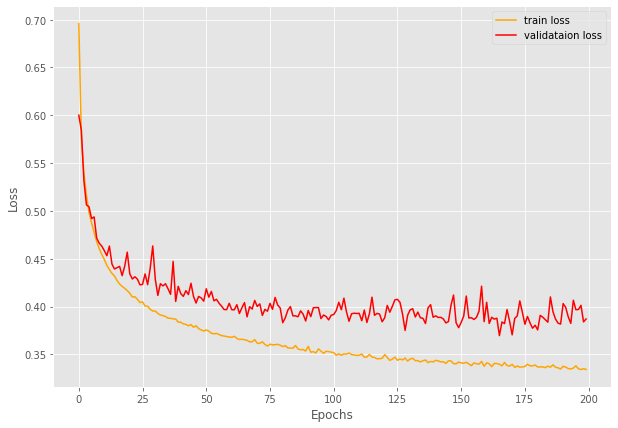

In [40]:
#torch.save({
#            'epoch': epochs,
#            'model_state_dict': final_classifier.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': criterion,
#            }, 'outputs/last_model_' + DATA_FOLDER_NAME + '.pth')


# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('outputs/loss_' + DATA_FOLDER_NAME + '.png')
plt.show()

In [41]:
checkpoint = torch.load('outputs/best_model_' + DATA_FOLDER_NAME + '.pth')
# load model weights state_dict
final_classifier.load_state_dict(checkpoint['model_state_dict'])

# test dataset
test_data = ClevrPOCDataSet(DATA_FOLDER, 'testing', total_labels_to_index, ENVIRONMENT_FOLDER)
# test data loader
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)


test_exact_acc, test_partial_acc = test(final_classifier, clip_model, test_loader, criterion, test_data, device, dropout, clip_preprocess, validation_threshold)
print('test_exact_acc', test_exact_acc)
print('test_partial_acc', test_partial_acc)


Testing


100%|███████████████████████████████████████| 1200/1200 [01:22<00:00, 14.59it/s]

test_exact_acc 0.22833333333333333
test_partial_acc 0.4465843253968251


In [42]:
print(3)

3
